In [44]:

from template_match import read_image_rgb, read_image_gray, template_match, \
    detect_points, find_tolerance_limit, simplify_points, point_to_bbox, agglomerative_clustering, meanshift_clustering

from process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy_indexed as npi

In [46]:
from ipywidgets import interact, widgets

In [47]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))


from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [48]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv
from setup_logger import logger


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [97]:
PLOT_NUMBER = 15
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

## Step-by-step pipeline

### 1) Draw image and marker

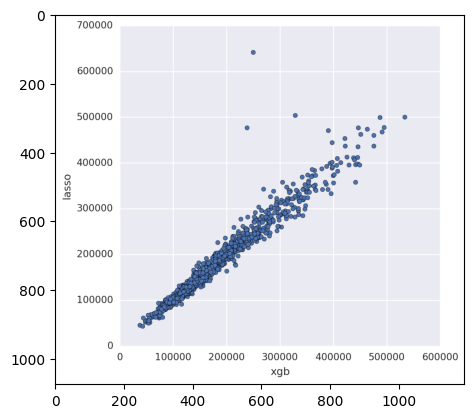

In [98]:
source_image = read_image_rgb(PLOT_PATH)
draw_image(source_image)

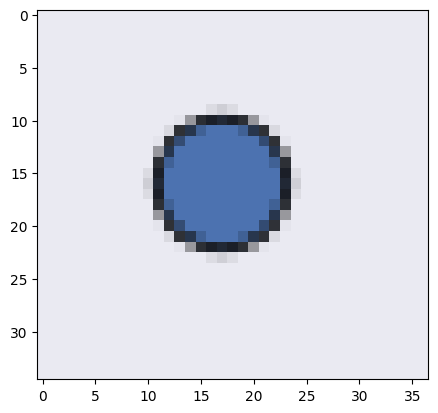

In [99]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

draw_image(template_rgb)

### 2) Template treshholding

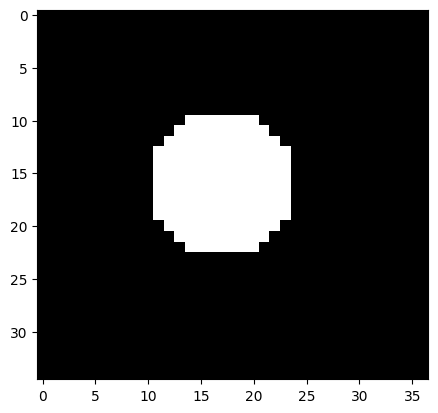

In [100]:
mask = template_tresholding(template_rgb, treshold=200)
draw_image(mask)

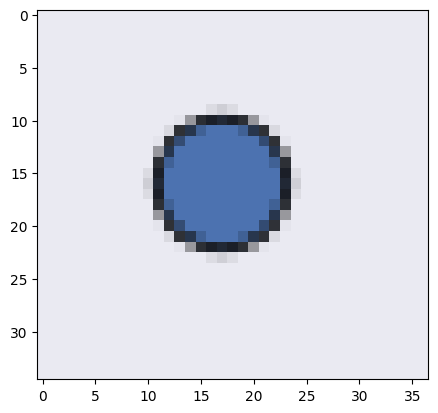

In [101]:
draw_image(template_rgb)
# draw_image(mask)

### 3) Template match, get convolution map

In [102]:
# template_rgb = template_final
# w, h = template_rgb.shape[1], template_rgb.shape[0]

# mask = mask_final

In [109]:
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
# method = 'cv.TM_CCOEFF_NORMED'
method = 'cv.TM_CCORR_NORMED'
# method = 'cv.TM_SQDIFF_NORMED'
# method = 'cv.TM_SQDIFF'


convolution_map, max_val = template_match(source_image, template_rgb, mask, method_name=method)

In [110]:
np.unique(convolution_map, return_counts=True)

(array([0.71282005, 0.71886665, 0.7235771 , ..., 0.9999939 , 0.99999654,
        1.        ], dtype=float32),
 array([ 1,  1,  1, ...,  2,  3, 29]))

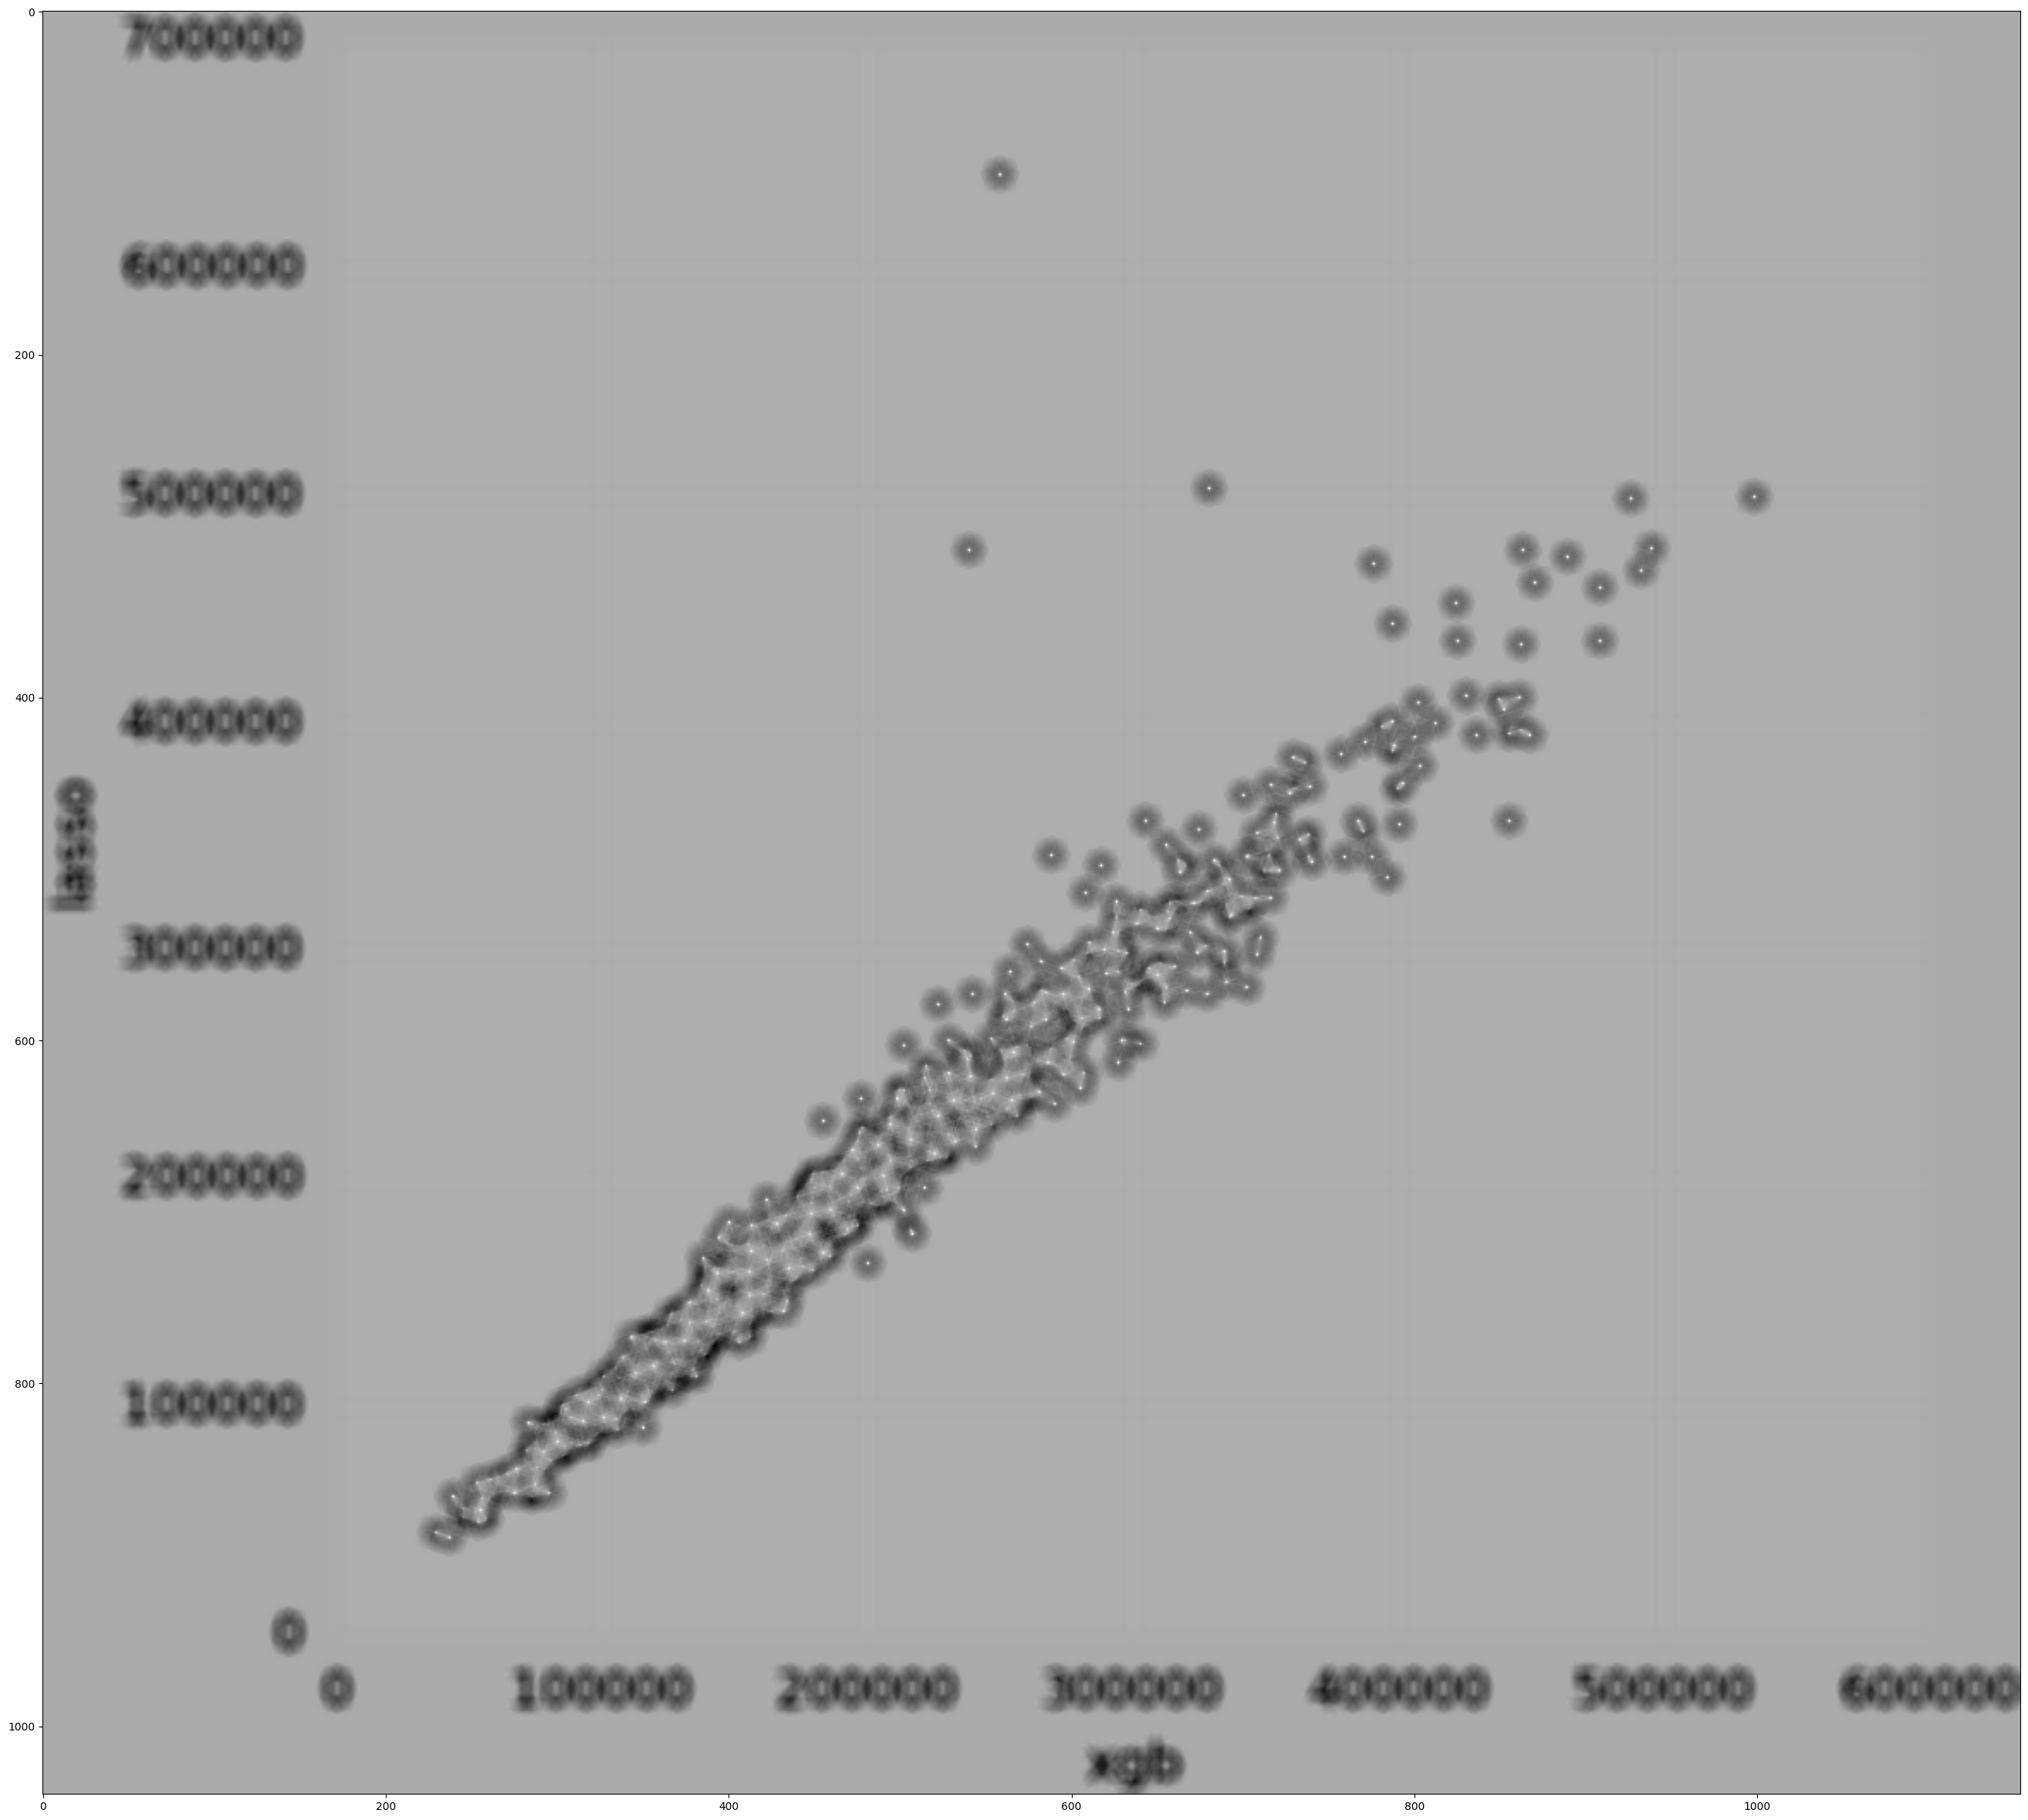

In [111]:
plt.figure(figsize=(60, 30))
plt.imshow(convolution_map, cmap="gray")

#### Convert point on convolution map to bbox on source image

In [14]:
index = np.where( convolution_map == 1.1025982)

# check
convolution_map[index]

array([], dtype=float32)

In [15]:
point_on_map = (index[0][0], index[1][0])

print(index)
print(point_on_map)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
bbox = point_to_bbox(*point_on_map, w, h, convolution_map)
x_min, x_max, y_min, y_max = bbox

In [17]:
assert source_image[y_min:y_max+1, x_min:x_max+1].shape == template_rgb.shape

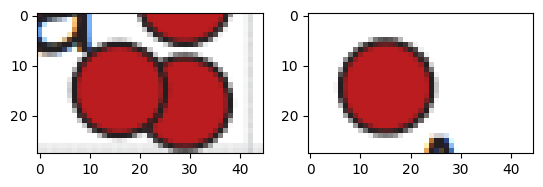

In [18]:
plt.subplot(1, 2, 1)
draw_image(source_image[y_min:y_max+1, x_min:x_max+1])


plt.subplot(1, 2, 2)
draw_image(template_rgb)

### Detect points example

In [286]:
points = detect_points(convolution_map, max_val, tolerance=0.007)
x = points[:, 0]
y = points[:, 1]

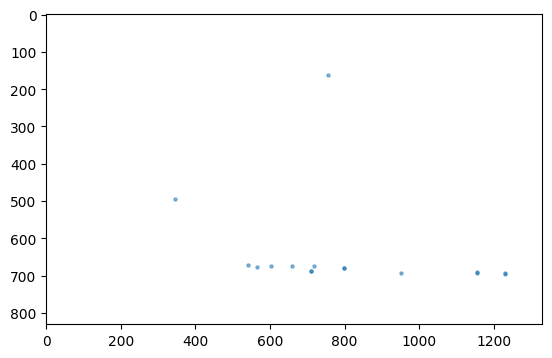

In [287]:
draw_points_on_canvas(points, source_image)

### 4) Find detection tolerance limit

In [112]:
tolerance_limit = find_tolerance_limit(convolution_map)
tolerance_limit

0.09

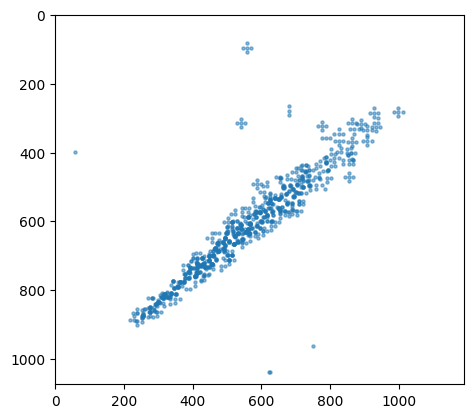

In [113]:
# run detection with limit tolerance value
points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, source_image)

### Clustering example

In [22]:
# eps = 15
# cluster_labels = agglomerative_clustering(points, eps)

bandwidth = 2
cluster_labels = meanshift_clustering(points, bandwidth)


cluster_centers = simplify_points(points, cluster_labels)

Text(0.5, 1.0, 'Points after clustering and simplification')

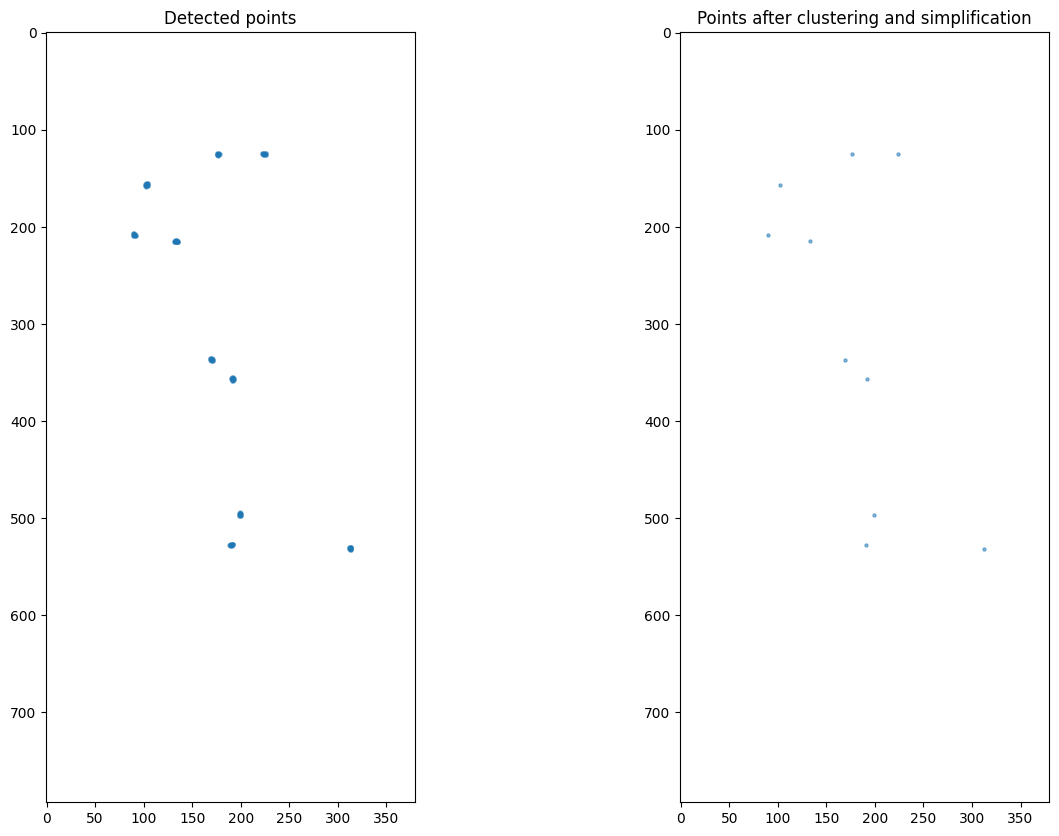

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
draw_points_on_canvas(points, source_image)
plt.title("Detected points")

plt.subplot(1, 2, 2)
draw_points_on_canvas(cluster_centers, source_image)
plt.title("Points after clustering and simplification")

In [31]:
bw = 4
cluster_labels = meanshift_clustering(points, bandwidth=bw)

cluster_centers = simplify_points(points, cluster_labels)

Text(0.5, 1.0, 'Points after clustering and simplification')

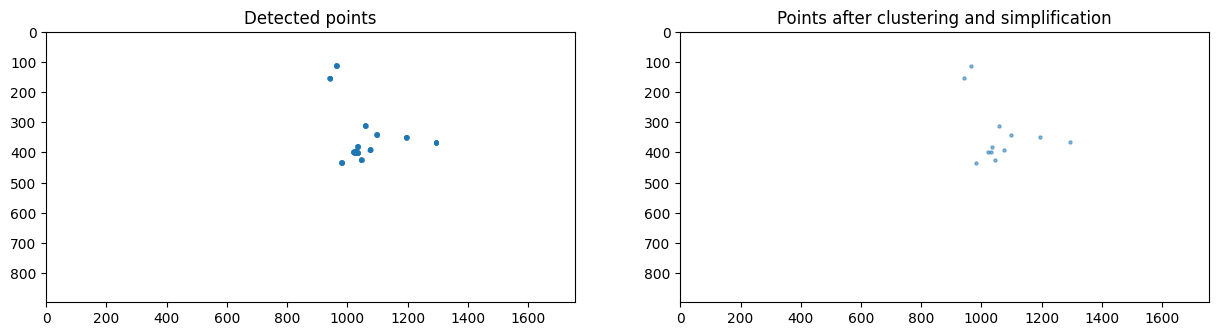

In [32]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
draw_points_on_canvas(points, source_image)
plt.title("Detected points")

plt.subplot(1, 2, 2)
draw_points_on_canvas(cluster_centers, source_image)
plt.title("Points after clustering and simplification")

**Clustering metrics**

In [216]:
# from scipy.spatial import distance
# n = len(points)

# rho = []
# I = []

# for i in range(n):
#     for j in range(i+1, n):
#         dist = distance.euclidean(points[i], points[j])
#         # print(dist)
#         I.append(labels_pred[i] == labels_pred[j])
#         rho.append(dist)

# I = np.array(I)
# rho = np.array(rho)

# I_f0 = I.astype(np.float64)
# I_f1 = 1 - I_f0

In [217]:
# F0 = np.sum(rho * I_f0) / np.sum(I_f0)
# F1 = np.sum(rho * I_f1) / np.sum(I_f1)

# F0, F1, F0 / F1

(18.61327050183725, 172.2479746536529)

### 5) Select best tolerance and eps


Need gloabal variables `convolution_map`, `max_val`, `w`, `h`

In [114]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.09, min=0.001, step=0.001), Floa…

## Step-by-step marker template processing

In [19]:
PLOT_NUMBER = 6
MARKER_NUMBER = 3

# PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

### 0) Treshholding

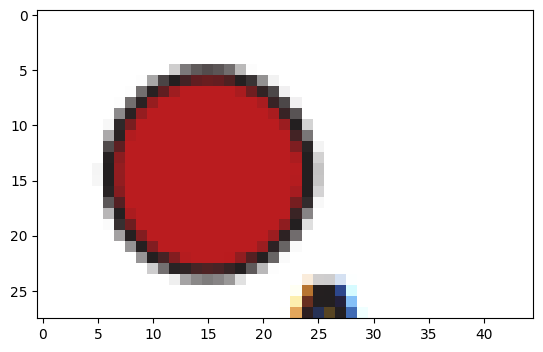

In [20]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

draw_image(template_rgb)

In [21]:
mask = template_tresholding(template_rgb, treshold=200)

In [22]:
### mask for debugging ###

# path_to_mask = str(DATA_PATH / "markers_orig" / "mask_example2.png")
# mask = cv.imread(path_to_mask)

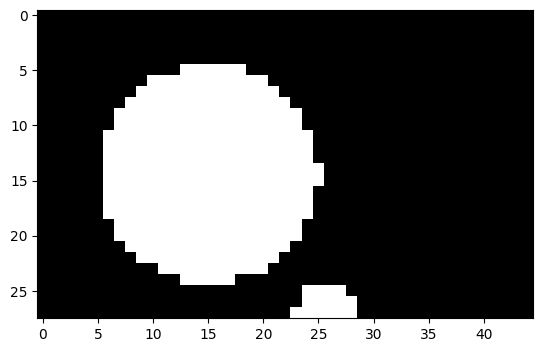

In [23]:
plt.imshow(mask, cmap="gray")

### 1) Find largest connected component

In [24]:
new_mask = extract_largest_component(mask)

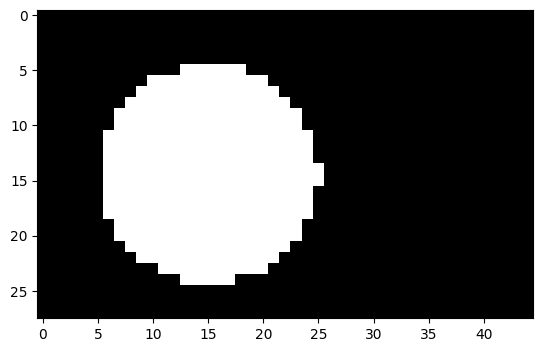

In [25]:
plt.imshow(new_mask, cmap="gray")

### 2) Find bbox around white component

In [42]:
bbox, bbox_center = find_bbox(new_mask)

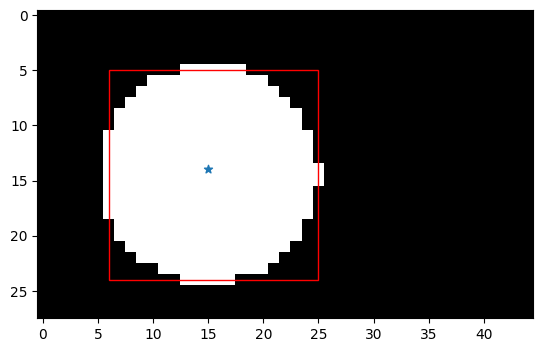

In [44]:
plt.imshow(new_mask, cmap="gray")

draw_bbox(*bbox, bbox_center=bbox_center)

### 3) Crop white component

In [28]:
cropped_mask = crop_image(new_mask, bbox)

cropped_template = crop_image(template_rgb, bbox)

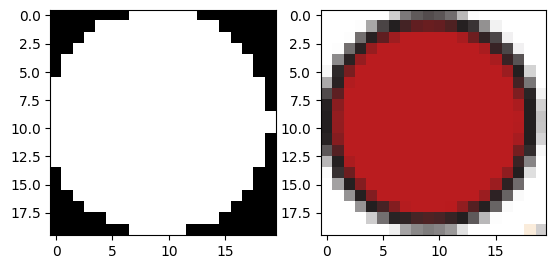

In [29]:
plt.subplot(1, 2, 1)
plt.imshow(cropped_mask, cmap="gray")

plt.subplot(1, 2, 2)
draw_image(cropped_template)

### 4) Add black frames

In [30]:
mask_final = frame_image(cropped_mask, frame_width=2)

template_final = frame_image(cropped_template, frame_width=2)

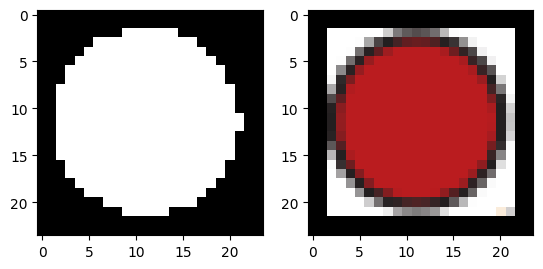

In [31]:
plt.subplot(1, 2, 1)
plt.imshow(mask_final, cmap="gray")

plt.subplot(1, 2, 2)
draw_image(template_final)

## Multi-template matching

In [7]:
PLOT_NUMBER = 11
MARKER_NUMBERS = [2, 3]

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"

TEMPLATE_PATHS = [DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUM}.png"
                  for MARKER_NUM in MARKER_NUMBERS]

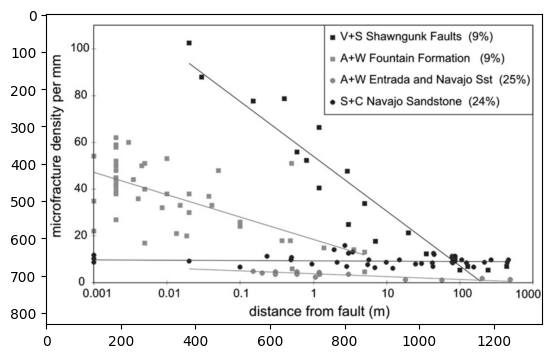

In [8]:
source_image = read_image_rgb(PLOT_PATH)
draw_image(source_image)

In [9]:
templates = [read_image_rgb(TEMPLATE_PATH) for TEMPLATE_PATH in TEMPLATE_PATHS]


w, h = templates[0].shape[1], templates[0].shape[0]

Text(0.5, 1.0, 'template 2')

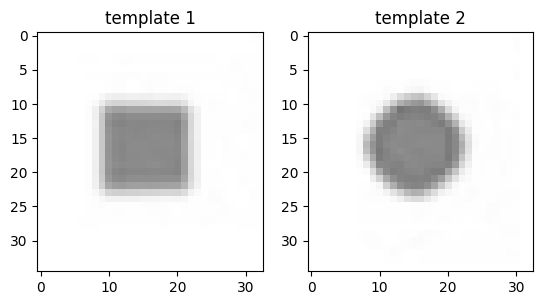

In [10]:
plt.subplot(1, 2, 1)
draw_image(templates[0])
plt.title("template 1")

plt.subplot(1, 2, 2)
draw_image(templates[1])
plt.title("template 2")

In [11]:
masks = [template_tresholding(template, treshold=200) for template in templates]

In [12]:
from template_match import invert_convolution_map


def multi_template_match(
    image: np.ndarray,
    templates: List[np.ndarray],
    template_masks: List[np.ndarray],
    method_name: str
) -> Tuple[List[np.ndarray], List[float]]:
    """ 
    Run opencv templateMatch on each template from list of templates.
    Return list of convolution maps and list of maximum values on each map.
    """
    method = eval(method_name)

    convolution_map_list = []
    max_val_list = []

    for template, template_mask in zip(templates, template_masks):

        convolution_map = cv.matchTemplate(image, template, method, mask=template_mask)
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED, cv.TM_CCORR]:
            logger.debug(f"Convolution map bounds: {np.min(convolution_map), np.max(convolution_map)}")
            logger.debug("Convolution map was inverted")
            convolution_map = invert_convolution_map(convolution_map)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(convolution_map)

        convolution_map_list.append(convolution_map)
        max_val_list.append(max_val)

    return convolution_map_list, max_val_list


In [13]:
def get_best_matches(convolution_map_list: List[np.ndarray]) -> np.ndarray:
    """
    Idea: At ech pixel of source image find which template gives
            maximum correlation value during template matching process.

    Return 2d array of the same size as convolution map.
    Each array value represents number of template (<=> label) that gives best match at this position. 
    """
    stacked_conv_maps = np.stack(convolution_map_list)

    # best_match_corr_values = np.max(stacked_conv_maps, axis=0)
    best_match_template_numbers = np.argmax(stacked_conv_maps, axis=0)
    return best_match_template_numbers

In [14]:
def detect_points_v2(
    convolution_map: np.ndarray,
    max_value: float,
    tolerance: float,
    best_match_map: np.ndarray,
    template_number: int
) -> np.ndarray:
    
    max_positions = np.where( np.isclose(convolution_map, max_value, atol=tolerance) )
    y, x = max_positions
    max_points = np.array([x, y]).T
    
    allowed_positions = np.where( best_match_map == template_number )
    y, x = allowed_positions
    points_with_allowed_positions = np.array([x, y]).T
    
    points = npi.intersection(max_points, points_with_allowed_positions)
    
    return points

In [27]:
%%time
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
# method = 'cv.TM_CCORR_NORMED'
# method = 'cv.TM_CCOEFF_NORMED'
method = 'cv.TM_SQDIFF_NORMED'
# method = 'cv.TM_SQDIFF'


convolution_map_list, max_val_list = multi_template_match(
    source_image, templates, masks, method_name=method
)


# convolution_map1, max_val1 = template_match(source_image, template1, mask1, method_name=method)
# convolution_map2, max_val2 = template_match(source_image, template2, mask2, method_name=method)
# assert convolution_map1.shape == convolution_map2.shape, "Corr map shapes are different"
# conv_map_height, conv_map_width = convolution_map1.shape

DEBUG - 290107941.py - multi_template_match: Convolution map bounds: (0.0, 2.1880565)
DEBUG - 290107941.py - multi_template_match: Convolution map was inverted


DEBUG - 290107941.py - multi_template_match: Convolution map bounds: (0.0, 2.1975756)
DEBUG - 290107941.py - multi_template_match: Convolution map was inverted


CPU times: user 261 ms, sys: 9.66 ms, total: 271 ms
Wall time: 268 ms


In [28]:
# check that all conv maps have same shape  # TODO: perform check that templates shapes are equal instead
for i in range(len(convolution_map_list) - 1):
    assert convolution_map_list[i].shape == convolution_map_list[i+1].shape

    # check that conv map differs (optional)
    assert not np.all(convolution_map_list[i] == convolution_map_list[i+1])


In [29]:
best_match_map = get_best_matches(convolution_map_list)

np.unique(best_match_map, return_counts=True)

(array([0, 1]), array([187816, 846690]))

In [34]:
TEMPLATE_NUM = 1


convolution_map = convolution_map_list[TEMPLATE_NUM]
max_val = max_val_list[TEMPLATE_NUM]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


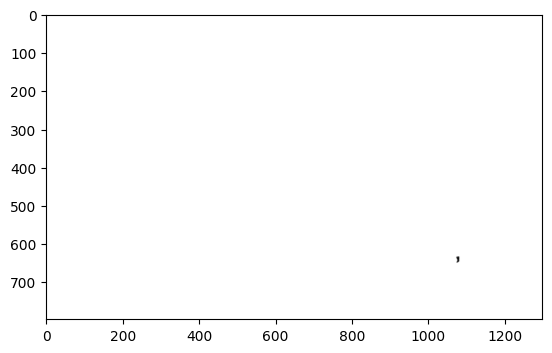

In [37]:
draw_image(convolution_map)

### Detect points example

In [38]:
tolerance = 0.003

points = detect_points_v2(
    convolution_map, max_val, tolerance,
    best_match_map, TEMPLATE_NUM
)

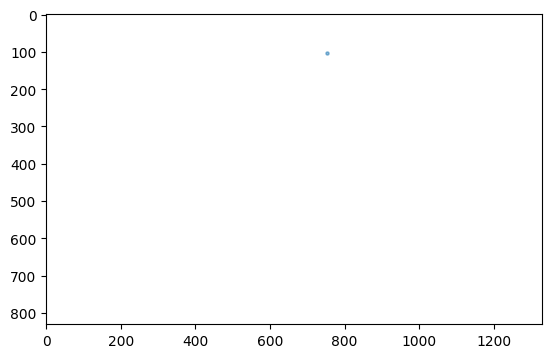

In [20]:
draw_points_on_canvas(points, source_image)

### Find detection tolerance limit

In [39]:
tolerance_limit = find_tolerance_limit(convolution_map)
tolerance_limit

0.056

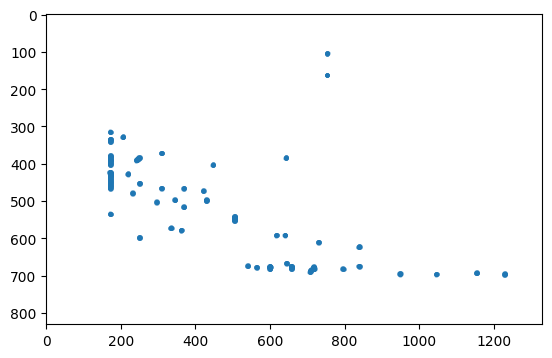

In [40]:
# run detection with limit tolerance value
points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, source_image)

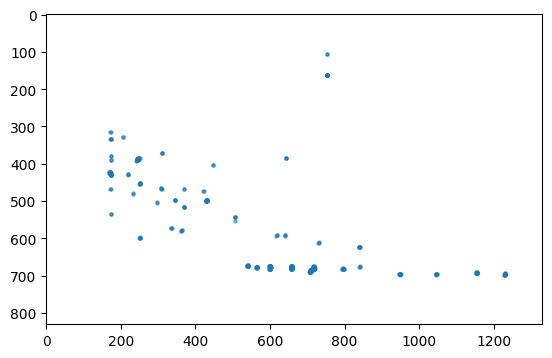

In [41]:
points = detect_points_v2(
    convolution_map, max_val, tolerance_limit,
    best_match_map, TEMPLATE_NUM
)
draw_points_on_canvas(points, source_image)

### Select best tolerance and eps


Need gloabal variables `best_match_map`, `TEMPLATE_NUM`, `convolution_map`, `max_val`, `w`, `h`

In [42]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.056, min=0.001, step=0.001), Flo…

In [43]:
@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(tolerance, eps):

    # points = detect_points_v2(convolution_map, max_val, tolerance=tolerance)
    points = detect_points_v2(
        convolution_map, max_val, tolerance,
        best_match_map, TEMPLATE_NUM
    )

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="red", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.056, min=0.001, step=0.001), Flo…

## Drafts

In [29]:
# draw_image(convolution_map_list[0])

In [52]:
[convolution_map_list[i][0, 1] for i in range(len(convolution_map_list))]

[0.99642336, 0.9903809]

In [92]:
%%time
conv_map_height, conv_map_width = convolution_map_list[0].shape
max_label_map = np.zeros_like(convolution_map_list[0], dtype=np.int32)
max_corr_map = np.zeros_like(convolution_map_list[0], dtype=np.float64)  # like max NCC in article 


for h in range(conv_map_height):
    for w in range(conv_map_width):
        conv_map_values = [convolution_map_list[i][h, w] for i in range(len(convolution_map_list))]
        
        assert len(conv_map_values) == 2
        max_corr_map[h, w] = np.max(conv_map_values)
        max_label_map[h, w] = np.argmax(conv_map_values)


np.unique(max_label_map, return_counts=True)

CPU times: user 7.33 s, sys: 0 ns, total: 7.33 s
Wall time: 7.33 s


(array([0, 1], dtype=int32), array([967963,  66543]))

In [76]:
%%time
label_map = np.zeros_like(convolution_map_list[0], dtype=np.int32)

for h in range(conv_map_height):
    for w in range(conv_map_width):
        conv_map_value1 = convolution_map_list[0][h, w]
        conv_map_value2 = convolution_map_list[1][h, w]

        if conv_map_value1 > conv_map_value2:
            label_map[h, w] = 1
        elif conv_map_value2 > conv_map_value1:
            label_map[h, w] = 2

np.unique(label_map, return_counts=True)

CPU times: user 725 ms, sys: 0 ns, total: 725 ms
Wall time: 723 ms


(array([1, 2], dtype=int32), array([967963,  66543]))

In [75]:
%%time
stacked_conv_maps = np.stack(convolution_map_list)

max_val_from_stacked_conv_maps = np.max(stacked_conv_maps, axis=0)

max_labels_from_stacked_conv_maps = np.argmax(stacked_conv_maps, axis=0)

CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 23.6 ms


In [96]:
np.all( max_val_from_stacked_conv_maps == max_corr_map )

True

In [93]:
np.all(max_label_map == max_labels_from_stacked_conv_maps)

True

In [191]:
tolerance = 0.01

In [192]:
_, max_val1, _, _ = cv.minMaxLoc(convolution_map2)
max_val1

1.0

In [193]:
max_positions1 = np.where( np.isclose(convolution_map2, max_val1, atol=tolerance) )
y, x = max_positions1
points = np.array([x, y]).T

In [194]:
points.shape

(731102, 2)

In [195]:
allowed_positions = np.where( label_map == 2 )
y, x = allowed_positions
allowed_positions_points = np.array([x, y]).T
allowed_positions_points.shape

(66543, 2)

In [ ]:
intersection = npi.intersection(points, allowed_positions_points)
intersection

In [196]:
# ## slower way to search intersection
# %%time
# b_set = set([tuple(x) for x in allowed_positions_points])
# a_set = set([tuple(x) for x in points])

# intersection = np.array([x for x in a_set & b_set])

CPU times: user 1.28 s, sys: 21 ms, total: 1.3 s
Wall time: 1.3 s


In [197]:
# intersection

In [109]:
A = np.array([[1, 4],
              [2, 5],
              [3, 6]])

B = np.array([[1, 4],
              [3, 6], 
              [7, 8]])

b_set = set([tuple(x) for x in B])
a_set = set([tuple(x) for x in A])

b_set

{(1, 4), (3, 6), (7, 8)}

In [110]:
np.array([x for x in a_set & b_set])

array([[1, 4],
       [3, 6]])

In [49]:
A = np.array([[1, 4],
              [2, 5],
              [3, 6]])

B = np.array([[2, 3],
              [3, 6], 
              [7, 8]])

C = np.array([[2, 3],
              [3, 6990], 
              [7, 8]])

D = np.array([[2, 3],
              [33, 6], 
              [7, 8]])

In [67]:
stacked2 = np.stack([A, B, C, D])

True

In [50]:
stacked = np.stack([A, B, C, D])

# stacked[:, 0, 0]
stacked

np.max(stacked, axis=0)

array([[[   1,    4],
        [   2,    5],
        [   3,    6]],

       [[   2,    3],
        [   3,    6],
        [   7,    8]],

       [[   2,    3],
        [   3, 6990],
        [   7,    8]],

       [[   2,    3],
        [  33,    6],
        [   7,    8]]])

In [51]:
np.max(stacked, axis=0)

array([[   2,    4],
       [  33, 6990],
       [   7,    8]])